# Titianic Kaggale

## Link: [Kaggle](https://www.kaggle.com/c/titanic)


## Loading Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (12.0, 10.0) # set default size of plots
%matplotlib inline

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## My libs
from tqdm import tqdm
from xgboost import XGBClassifier
import xgboost as xgb

## Load Data

In [504]:
# Load in the train and test datasets
Train = pd.read_csv('Data/train.csv')
Test = pd.read_csv('Data/test.csv')

# Store our passenger ID for easy access
PassengerId = Test['PassengerId']

## head
#Train.head(10)
# '''
# Variable	Definition	Key
# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
# sex	Sex	
# Age	Age in years	
# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	
# ticket	Ticket number	
# fare	Passenger fare	
# cabin	Cabin number	
# embarked	Port of Embarkation
# '''

## Data Inspection

In [506]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


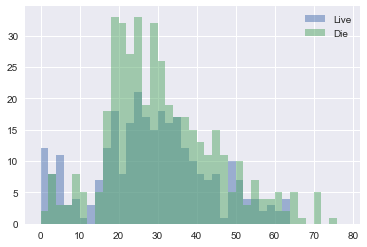

In [435]:
#print(Train.columns, test.columns)
#print (Train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
#print (Train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
#print (Train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean())
#print (Train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean())
#print (Train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean())
#print (Train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean())
#print (Train[["Cabin", "Survived"]].groupby(['Cabin'], as_index=False).mean())
plt.clf()
pltstr = "Age"
Train.loc[Train['Survived'] == 1, pltstr].hist(bins=np.arange(0, 80, 2), alpha=0.5, label="Live")
Train.loc[Train['Survived'] == 0, pltstr].hist(bins=np.arange(0, 80, 2), alpha=0.5, label="Die")
plt.legend()
plt.show()

In [436]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def get_number(name):
    if " " in name:
        s = name.split(" ")[1]
    else:
        s = name
    num_search = re.findall('\d+', s)
    # If the title exists, extract and return it.
    if num_search:
        return int(num_search[0])
    return 0

# Train['tickn'] = Train['Ticket'].apply(get_number)
# #print (Train[["tickn", "Survived"]].groupby(['tickn'], as_index=False).mean())
# Train.loc[Train['Survived'] == 1, 'tickn'].hist(bins=np.arange(0, 40000, 1000), alpha=0.5, label="live")
# Train.loc[Train['Survived'] == 0, 'tickn'].hist(bins=np.arange(0, 40000, 1000), alpha=0.5, label="die")
# plt.legend()
# plt.show()

In [553]:
full_data = [copy.deepcopy(Train), copy.deepcopy(Test)]

for dataset in full_data:
    
    # Gives the length of the name
    dataset['Name_length'] = dataset['Name'].apply(len)
    
    # Feature that tells whether a passenger had a cabin on the Titanic
    #dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == str else 1)
    dataset['CabinClass'] = dataset['Cabin'].fillna("Z0").apply(lambda x: x.replace(" ", "")[0])
    dataset['CabinClass'] = dataset['CabinClass'].map( 
        {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E':4, 'F':5, "G":6, "T":7, "Z":7}).astype(int)
    dataset['CabinNumber'] = dataset['Cabin'].fillna("Z0").apply(lambda x: int(x.split(" ")[0][1:] + "0")/10)
    
    # Mapping CabinNumber
    dataset.loc[ dataset['CabinNumber'] <= 0, 'CabinNumber']                               = 0
    dataset.loc[ (dataset['CabinNumber'] > 0) & (dataset['CabinNumber'] <= 10), 'CabinNumber']  = 1
    dataset.loc[ (dataset['CabinNumber'] > 10) & (dataset['CabinNumber'] <= 40), 'CabinNumber']  = 2
    dataset.loc[ (dataset['CabinNumber'] > 40), 'CabinNumber']  = 3
    dataset['CabinNumber'] = dataset['CabinNumber'].astype(int)
    
    # Feature engineering steps taken from Sina
    # Create new feature FamilySize as a combination of SibSp and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['FamilySize'] = dataset['FamilySize'].apply(lambda x: 5 if (x >=5 and x < 8) else x) ##group family 5,6,7 to 5
    dataset['FamilySize'] = dataset['FamilySize'].apply(lambda x: 6 if x >= 8 else x) ##no family > 8 survived
    
#     # Create new feature IsAlone from FamilySize
#     dataset['IsAlone'] = 0
#     dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

    # Remove all NULLS in the Embarked column
    dataset['Embarked'] = dataset['Embarked'].fillna('Z')

    # Create a new feature CategoricalFare
    # Remove all NULLS in the Fare column and 
    # Maybe not Median?
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['CategoricalFare'] = pd.qcut(dataset['Fare'], 4)

    # Create a New feature of ticket number
    dataset['TickN'] = dataset['Ticket'].apply(get_number)
    dataset['TickN'] = dataset['TickN'] // 10000
    
    # Create a New feature CategoricalAge
    # This could be engineered?
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['CategoricalAge'] = pd.cut(dataset['Age'], 5)
    
    # Create a new feature Title, containing the titles of passenger names
    dataset['Title'] = dataset['Name'].apply(get_title)
    # Group all non-common titles into one single grouping "Rare"
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1, '': 2} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2, 'Z': 3} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] == 0, 'Fare']                                  = 0
    dataset.loc[(dataset['Fare'] > 0) & (dataset['Fare'] <= 7.91), 'Fare']      = 1
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 2
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 100), 'Fare']      = 4
    dataset.loc[(dataset['Fare'] > 100), 'Fare']                                = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 4, 'Age']                           = 0
    dataset.loc[(dataset['Age'] > 4) & (dataset['Age'] <= 16), 'Age']  = 1
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 48), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 4
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 5

/Users/renormalization/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [554]:
## Data cleaining; only for training!
full_data[0] = full_data[0].loc[full_data[0]["Fare"] >  0] ##clean those who didn't pay
#full_data[0].loc[full_data[0]["Fare"] >= 0][["Fare", "Survived"]].groupby(['Fare'], as_index=False).mean()

In [555]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'CategoricalAge', 'CategoricalFare']
for dataset in full_data:
    dataset.drop(drop_elements, axis = 1, inplace=True)
    #print(dataset.head(3))

In [556]:
train = full_data[0]
test  = full_data[1]
print(train.shape, test.shape)

(876, 12) (418, 11)


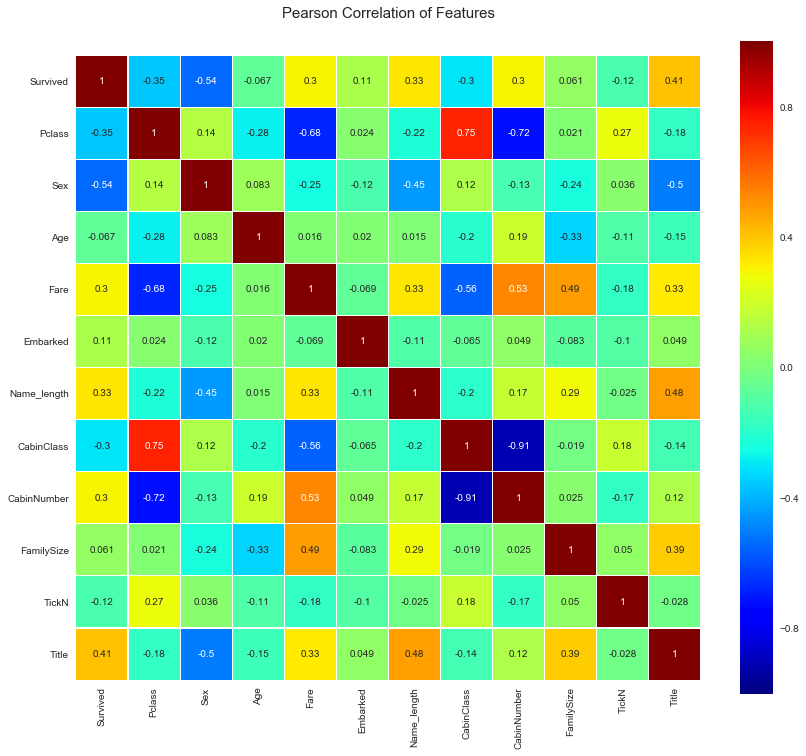

In [557]:
colormap = plt.cm.jet
plt.clf()
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Let's XGboost and CV this

In [558]:
train_t, val_t = train_test_split(train, train_size=0.9, test_size=0.1)
# X_train = train_t.drop("Survived", axis=1)
# y_train = train_t["Survived"]
# X_val = val_t.drop("Survived", axis=1)
# y_val = val_t["Survived"]

In [693]:
## A new more systematic approach
def modelfit(alg, dtrain, useTrainCV=True, param_grid={}, cv_folds=5, early_stopping_rounds=50):
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#https://www.dataiku.com/learn/guide/code/python/advanced-xgboost-tuning.html
    
    t_size = 0.9 ##don't split trianing
    df_tr_temp, df_vr_temp = train_test_split(dtrain, train_size=t_size, test_size=1 - t_size, shuffle=False)
    X_tr_temp = df_tr_temp.drop("Survived", axis=1)
    y_tr_temp = df_tr_temp["Survived"]
    X_vr_temp = df_vr_temp.drop("Survived", axis=1)
    y_vr_temp = df_vr_temp["Survived"]
    
    if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["is_sig"].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
        
        scoring = {'AUC': 'roc_auc', 'Accuracy': metrics.make_scorer(metrics.accuracy_score)}
        
        ##Randomized Search CV
        gsearch = RandomizedSearchCV(estimator = alg, param_distributions = param_grid, n_iter=50, cv=5, n_jobs=2)
        
        #Grid search CV
        #gsearch = GridSearchCV(estimator = alg, param_grid = param_grid, n_jobs=3, iid=False, cv=5, scoring=scoring, return_train_score=True, refit="AUC")
        
        ##Search
        gsearch.fit(X_tr_temp, y_tr_temp)
        
#         ##check trend
#         results = gsearch.cv_results_
#         plt.clf()
#         plt.figure(figsize=(13, 13))
#         plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)
#         plt.xlabel("Parameter")
#         plt.ylabel("Score")
#         plt.grid()

#         ax = plt.axes()
#         ax.set_xlim(0, 1)
#         ax.set_ylim(0.75, 1)

#         # Get the regular numpy array from the MaskedArray
#         X_axis = np.array(results['param_' + "min_child_weight"].data, dtype=float)

#         for scorer, color in zip(sorted(scoring), ['g', 'k']):
#             for sample, style in (('train', '--'), ('test', '-')):
#                 sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
#                 sample_score_std = results['std_%s_%s' % (sample, scorer)]
#                 ax.fill_between(X_axis, sample_score_mean - sample_score_std,
#                                 sample_score_mean + sample_score_std,
#                                 alpha=0.1 if sample == 'test' else 0, color=color)
#                 ax.plot(X_axis, sample_score_mean, style, color=color,
#                         alpha=1 if sample == 'test' else 0.7,
#                         label="%s (%s)" % (scorer, sample))

#             best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
#             best_score = results['mean_test_%s' % scorer][best_index]

#             # Plot a dotted vertical line at the best score for that scorer marked by x
#             ax.plot([X_axis[best_index], ] * 2, [0, best_score],
#                     linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

#             # Annotate the best score for that scorer
#             ax.annotate("%0.2f" % best_score,
#                         (X_axis[best_index], best_score + 0.005))

#         plt.legend(loc="best")
#         plt.grid('off')
#         plt.show()

        ## from the documentation
        best_parameters = gsearch.best_params_
        score = gsearch.best_score_
        print(best_parameters, score)
        alg = gsearch.best_estimator_
    
    ## fit alg
    alg.fit(X_tr_temp, y_tr_temp, sample_weight=None, eval_set=[(X_tr_temp, y_tr_temp), (X_vr_temp, y_vr_temp)], eval_metric="error", verbose=False)
    
    #Predict training set:
    tr_predictions = alg.predict(X_tr_temp)
    tr_predprob    = alg.predict_proba(X_tr_temp)[:,1]
    vr_predictions = alg.predict(X_vr_temp)
    vr_predprob    = alg.predict_proba(X_vr_temp)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Train Accuracy : %.4g" % metrics.accuracy_score(y_tr_temp.values, tr_predictions))
    print("Train AUC Score (Train): %f" % metrics.roc_auc_score(y_tr_temp, tr_predprob))
    #Validation report
    print("Val Accuracy : %.4g" % metrics.accuracy_score(y_vr_temp.values, vr_predictions))
    print("Val AUC Score (Val): %f" % metrics.roc_auc_score(y_vr_temp, vr_predprob))
    
    return alg

In [694]:
def training(df, name="xgb_temp", optimize=False):
    
    param_grid = {
            'learning_rate': np.arange(1e-3, 1e-2, 1e-3), #np.arange(0.001, 0.3, 0.005), ##0.026
            'max_depth': np.arange(3, 8, 1), ##prefer smaller values, 4
            'gamma' : np.arange(0.006, 0.01, 0.001), ##insensitive
            'n_estimators' : np.arange(30, 100, 10), ##best around 75
            'colsample_bytree': [.6, .7, .8], ##best 1
            'reg_alpha' : np.arange(0.2, 0.4, 0.05), ##insensitive
            'subsample' : [.5, .6, .7, ], ##best 1
            'min_child_weight' : [.5, .6, .7, .8],
    }
    
    if optimize:
        xgb_temp = XGBClassifier(objective= 'binary:logistic')
        xgb_temp = modelfit(xgb_temp, df, param_grid=param_grid)
        #joblib.dump(param_grid.best_estimator_, name + ".parlib.dat")
    else:
        xgb_temp = XGBClassifier(
            max_depth = 4, #Maximum tree depth for base learners.
            learning_rate = 1e-7, #Boosting learning rate (XGBoost's "eta")
            n_estimators= 25, ## Number of boosted trees, CV doesn't change after ~ 90
            ##silent = False, ##print messages or not
            objective= 'binary:logistic',
            nthread=-1,
            gamma=0.01, #Minimum loss reduction required to make a further partition on a leaf node of the tree.
            min_child_weight=1, # Minimum sum of instance weight(hessian) needed in a child.
            scale_pos_weight=1,
            reg_alpha=0.2,
            reg_lambda=0.1,
            subsample=0.7, #Subsample ratio of the training instance.
            colsample_bytree = 0.7, #Subsample ratio of columns when constructing each tree.
            seed=24)
        xgb_temp = modelfit(xgb_temp, df, useTrainCV=False)
    
    ##save model
    joblib.dump(xgb_temp, name + ".joblib.dat")
    ##load model
    #loaded_model = joblib.load("pima.joblib.dat")
    
#     ##finish and plot
#     plt.clf()
#     fig = plt.figure(figsize=(10,6))
#     feat_imp = pd.Series(xgb_temp._Booster.get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
#     plt.savefig('Plot/feature_ranking_' + name + '.pdf')
    
    return xgb_temp

# Test performance on test set
def evaluate(alg):
    X_vr_temp = val_t.drop("Survived", axis=1)
    y_vr_temp = val_t["Survived"]
    vr_predictions = alg.predict(X_vr_temp)
    vr_predprob    = alg.predict_proba(X_vr_temp)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Test Accuracy : %.4g" % metrics.accuracy_score(y_vr_temp.values, vr_predictions))
    print("Test AUC Score (Test): %f" % metrics.roc_auc_score(y_vr_temp, vr_predprob))
    #Validation report

In [703]:
xgb_0 = training(train_t, name="xgb_0", optimize=True)
evaluate(xgb_0)

{'subsample': 0.5, 'reg_alpha': 0.25, 'n_estimators': 40, 'min_child_weight': 0.6, 'max_depth': 3, 'learning_rate': 0.001, 'gamma': 0.0070000000000000001, 'colsample_bytree': 0.6} 0.833568406206

Model Report
Train Accuracy : 0.8322
Train AUC Score (Train): 0.885784
Val Accuracy : 0.7975
Val AUC Score (Val): 0.901596

Model Report
Test Accuracy : 0.8068
Test AUC Score (Test): 0.893391


In [686]:
xgb_0 = training(train_t, name="xgb_0", optimize=False)
evaluate(xgb_0)


Model Report
Train Accuracy : 0.8505
Train AUC Score (Train): 0.903201
Val Accuracy : 0.8354
Val AUC Score (Val): 0.919215

Model Report
Test Accuracy : 0.8182
Test AUC Score (Test): 0.897989


In [702]:
# Generate Submission File 
model = xgb_0
predictions = model.predict(test)
submit = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
submit.head()
submit.to_csv("Data/Submission.csv", index=False)